### Volkswagen Data Time Series Analysis

In [29]:
# importing packages

import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace import sarimax
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest
from arch import arch_model
import seaborn as sns
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

In [30]:
# importing data

raw_data = yfinance.download(tickers= "VOW3.DE, PAH3.DE, BMW.DE", interval='1d',group_by='ticker',
                             auto_adjust= True, threads=True)

[*********************100%***********************]  3 of 3 completed


In [31]:
df = raw_data.copy()
df.tail()

Ticker        PAH3.DE                                               VOW3.DE  \
Price            Open       High        Low      Close    Volume       Open   
Date                                                                          
2025-05-14  38.090000  38.090000  38.090000  38.090000       0.0  98.460136   
2025-05-15  38.029999  38.419998  37.840000  37.980000  656601.0  96.771449   
2025-05-16  37.980000  37.980000  37.980000  37.980000       0.0  97.568886   
2025-05-19  37.990002  38.299999  37.040001  37.290001  787877.0  97.000000   
2025-05-20  37.200001  37.959999  37.060001  37.959999  592401.0  97.699997   

Ticker                                                     BMW.DE             \
Price            High        Low      Close     Volume       Open       High   
Date                                                                           
2025-05-14  98.460136  98.460136  98.460136        0.0  79.680008  79.680008   
2025-05-15  97.662701  96.536909  97.381256   798333.0  78.099998  78.919998   
2025-05-16  98.131782  95.833287  96.489998  1518948.0  77.680000  78.180000   
2025-05-19  98.620003  96.800003  97.500000  1444026.0  76.699997  77.720001   
2025-05-20  98.699997  96.839996  98.160004   859858.0  77.540001  79.519997   

Ticker                                     
Price             Low      Close   Volume  
Date                                       
2025-05-14  79.680008  79.680008        0  
2025-05-15  77.160004  77.580002  1229215  
2025-05-16  76.660004  76.919998  1029744  
2025-05-19  76.699997  77.559998   579046  
2025-05-20  76.519997  79.300003  1709643

In [32]:
# Defining Key Dates

# starting date
start_date = '2009-04-05'

# first official announcement 49.9%
ann_1 = '2009-12-09'

# second official announcement 50.1
ann_2 = '2012-07-05'

#ending date
end_date = '2014-01-01'

# dieselgate
d_gate = '2015-09-20'

#### Data Preprocessing

In [33]:
# extracting closing prices

df['vol'] = df['VOW3.DE'].Close
df['por'] = df['PAH3.DE'].Close
df['bmw'] = df['BMW.DE'].Close

# creating returns

df['ret_vol'] = df['vol'].pct_change(1).mul(100)
df['ret_por'] = df['por'].pct_change(1).mul(100)
df['ret_bmw'] = df['bmw'].pct_change(1).mul(100)

# creating squared returns

df['sq_vol'] = df.ret_vol.mul(df.ret_vol)
df['sq_por'] = df.ret_por.mul(df.ret_por)
df['sq_bmw'] = df.ret_bmw.mul(df.ret_bmw)

# extracting volume

df['q_vol'] = df['VOW3.DE'].Volume
df['q_por'] = df['PAH3.DE'].Volume
df['q_bmw'] = df['BMW.DE'].Volume

In [34]:
# assigning frequency and the fill missing data

df = df.asfreq('b')
df = df.fillna(method='ffill')

In [35]:
# removing surplus data

del df['VOW3.DE']
del df['PAH3.DE']
del df['BMW.DE']

df.tail()

Ticker,vol,por,bmw,ret_vol,ret_por,ret_bmw,sq_vol,sq_por,sq_bmw,q_vol,q_por,q_bmw
Price,,,,,,,,,,,,
Date,,,,,,,,,,,,
2025-05-14,98.460136,38.090000,79.680008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2025-05-15,97.381256,37.980000,77.580002,-1.095753,-0.288791,-2.635550,1.200676,0.083400,6.946122,798333.0,656601.0,1229215.0
2025-05-16,96.489998,37.980000,76.919998,-0.915226,0.000000,-0.850739,0.837638,0.000000,0.723758,1518948.0,0.0,1029744.0
2025-05-19,97.500000,37.290001,77.559998,1.046743,-1.816742,0.832033,1.095671,3.300552,0.692278,1444026.0,787877.0,579046.0
2025-05-20,98.160004,37.959999,79.300003,0.676927,1.796723,2.243432,0.458230,3.228215,5.032985,859858.0,592401.0,1709643.0


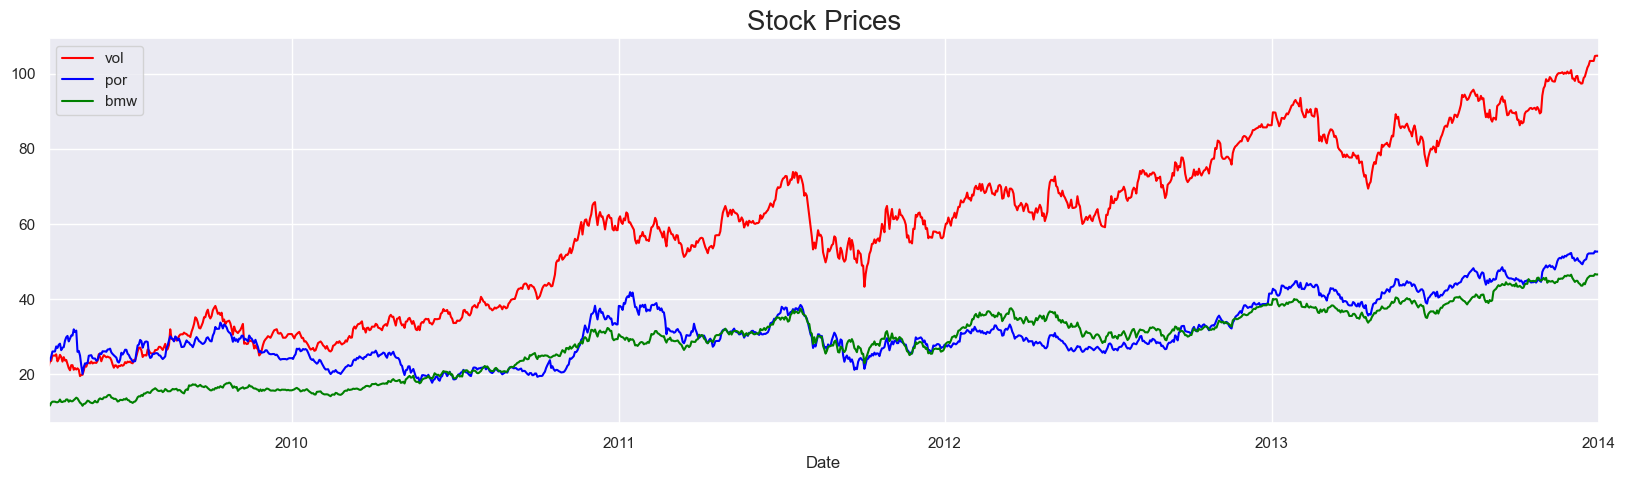

In [36]:
# plotting stock price data

df['vol'][start_date:end_date].plot(figsize=(20,5),color = 'red')
df['por'][start_date:end_date].plot(color = 'blue')
df['bmw'][start_date:end_date].plot(color = 'green')
plt.title('Stock Prices', size=20)
plt.legend()
plt.show()

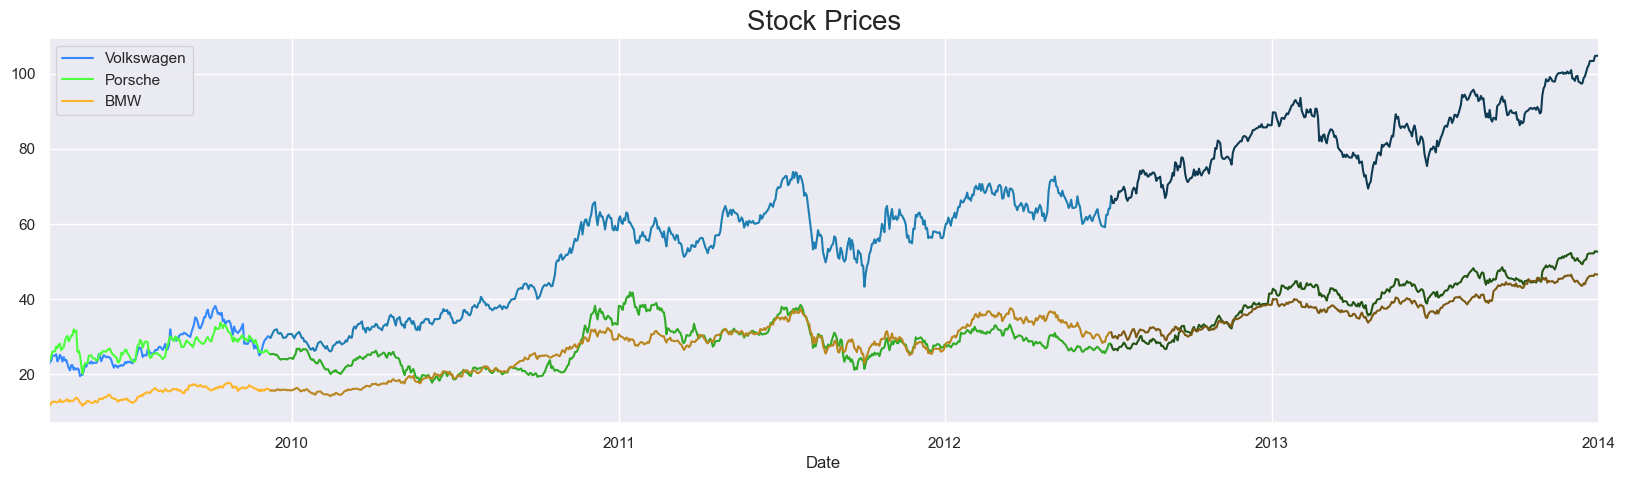

In [37]:
# plotting different intervals with different shades of colours to have a better idea

df['vol'][start_date:ann_1].plot(figsize=(20,5),color = '#3388FF')
df['por'][start_date:ann_1].plot(color = '#49FF3A')
df['bmw'][start_date:ann_1].plot(color = '#FEB628')

df['vol'][ann_1:ann_2].plot(color = '#1E7EB2')
df['por'][ann_1:ann_2].plot(color = '#2FAB25')
df['bmw'][ann_1:ann_2].plot(color = '#BA861F')

df['vol'][ann_2:end_date].plot(color = '#0E3A52')
df['por'][ann_2:end_date].plot(color = '#225414')
df['bmw'][ann_2:end_date].plot(color = '#7C5913')

plt.title('Stock Prices', size=20)
plt.legend(['Volkswagen','Porsche','BMW'])
plt.show()

#### Correlation

In [38]:
print ('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(end_date) +'\n')
print('Volkswagen and Porsche Correlation: \t' + str(df['vol'][start_date:end_date].corr(df['por'][start_date:end_date])))
print('Volkswagen and BMW Correlation: \t' + str(df['vol'][start_date:end_date].corr(df['bmw'][start_date:end_date])))
print('Porsche and BMW Correlation: \t' + str(df['por'][start_date:end_date].corr(df['bmw'][start_date:end_date])))

Correlation among manufacturers from 2009-04-05 to 2014-01-01

Volkswagen and Porsche Correlation: 	0.8364634981581357
Volkswagen and BMW Correlation: 	0.9798969059872741
Porsche and BMW Correlation: 	0.8057254193305515


In [39]:
print ('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(ann_1) +'\n')
print('Volkswagen and Porsche Correlation: \t' + str(df['vol'][start_date:ann_1].corr(df['por'][start_date:ann_1])))
print('Volkswagen and BMW Correlation: \t' + str(df['vol'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))
print('Porsche and BMW Correlation: \t' + str(df['por'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))

Correlation among manufacturers from 2009-04-05 to 2009-12-09

Volkswagen and Porsche Correlation: 	0.6762282488850061
Volkswagen and BMW Correlation: 	0.8441703206297485
Porsche and BMW Correlation: 	0.6217077582675667


This suggests that the stock prices for these brands weren't too similar before the start of the buyout.

In [40]:
print ('Correlation among manufacturers from ' + str(ann_1) + ' to ' + str(ann_2) +'\n')
print('Volkswagen and Porsche Correlation: \t' + str(df['vol'][ann_1:ann_2].corr(df['por'][ann_1:ann_2])))
print('Volkswagen and BMW Correlation: \t' + str(df['vol'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))
print('Porsche and BMW Correlation: \t' + str(df['por'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))

Correlation among manufacturers from 2009-12-09 to 2012-07-05

Volkswagen and Porsche Correlation: 	0.7434173057925535
Volkswagen and BMW Correlation: 	0.979587790559441
Porsche and BMW Correlation: 	0.7051170650438138


In [41]:
print ('Correlation among manufacturers from ' + str(ann_2) + ' to ' + str(end_date) +'\n')
print('Volkswagen and Porsche Correlation: \t' + str(df['vol'][ann_2:end_date].corr(df['por'][ann_2:end_date])))
print('Volkswagen and BMW Correlation: \t' + str(df['vol'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))
print('Porsche and BMW Correlation: \t' + str(df['por'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))

Correlation among manufacturers from 2012-07-05 to 2014-01-01

Volkswagen and Porsche Correlation: 	0.9409608958966498
Volkswagen and BMW Correlation: 	0.9291130993334872
Porsche and BMW Correlation: 	0.9497200004702956


In [42]:
print ('Correlation among manufacturers from ' + str(end_date) + ' to ' + str(df.index[-1]) +'\n')
print('Volkswagen and Porsche Correlation: \t' + str(df['vol'][end_date:].corr(df['por'][end_date:])))
print('Volkswagen and BMW Correlation: \t' + str(df['vol'][end_date:].corr(df['bmw'][end_date:])))
print('Porsche and BMW Correlation: \t' + str(df['por'][end_date:].corr(df['bmw'][end_date:])))

Correlation among manufacturers from 2014-01-01 to 2025-05-20 00:00:00

Volkswagen and Porsche Correlation: 	0.836584674275261
Volkswagen and BMW Correlation: 	0.48255121475823076
Porsche and BMW Correlation: 	0.20847319231824699


#### Best Fitting Models

##### For Volkswagen

In [43]:
mod_pr_pre_vol = auto_arima(df.vol[start_date:ann_1],exogenous = df[['por','bmw']][start_date:ann_1],
                            m=5,max_p=5,max_q=5)
mod_pr_btn_vol = auto_arima(df.vol[ann_1:ann_2],exogenous = df[['por','bmw']][ann_1:ann_2],
                            m=5,max_p=5,max_q=5)
mod_pr_post_vol = auto_arima(df.vol[ann_2:end_date],exogenous = df[['por','bmw']][ann_2:end_date],
                            m=5,max_p=5,max_q=5)

In [44]:
mod_pr_pre_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -247.363
Date:                Wed, 21 May 2025   AIC                            496.725
Time:                        11:46:02   BIC                            499.902
Sample:                    04-06-2009   HQIC                           498.014
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.9581      0.053     17.983      0.000       0.854       1.062
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):               232.52
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               2.10   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMAX(0, 1, 0) with no seasonal components, so it simplifies to an ARIMA(0, 1, 0) model.The model uses the first difference of the series and assumes the differenced series is white noise.This is equivalent to a random walk model — a very simple yet powerful model in time series.

When your time series is non-stationary and becomes stationary after one differencing.

There are no clear autoregressive or moving average patterns.

You want a baseline or naive forecast mode.

In [45]:
mod_pr_btn_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1125.453
Date:                Wed, 21 May 2025   AIC                           2252.906
Time:                        11:46:02   BIC                           2257.414
Sample:                    12-09-2009   HQIC                          2254.652
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.6764      0.066     25.213      0.000       1.546       1.807
===================================================================================
Ljung-Box (L1) (Q):                   1.99   Jarque-Bera (JB):                90.14
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               5.51   Skew:                             0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Similar to the previous model.

In [46]:
mod_pr_post_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -634.515
Date:                Wed, 21 May 2025   AIC                           1273.029
Time:                        11:46:02   BIC                           1280.956
Sample:                    07-05-2012   HQIC                          1276.172
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0783      0.047      1.662      0.097      -0.014       0.171
sigma2         1.5287      0.079     19.262      0.000       1.373       1.684
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                65.38
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                            -0.16
Prob(H) (two-sided):                  0.51   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This is essentially an ARIMA(1, 1, 0) model.Uses one lagged value of the series.Differencing once to remove trend (make it stationary). No MA component (no lagged forecast errors).

##### For Porsche

In [47]:
mod_pr_pre_por = auto_arima(df.por[start_date:ann_1],exogenous = df[['vol','bmw']][start_date:ann_1],
                            m=5,max_p=5,max_q=5)
mod_pr_btn_por = auto_arima(df.por[ann_1:ann_2],exogenous = df[['vol','bmw']][ann_1:ann_2],
                            m=5,max_p=5,max_q=5)
mod_pr_post_por = auto_arima(df.por[ann_2:end_date],exogenous = df[['vol','bmw']][ann_2:end_date],
                            m=5,max_p=5,max_q=5)

In [48]:
mod_pr_pre_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -245.755
Date:                Wed, 21 May 2025   AIC                            493.510
Time:                        11:46:19   BIC                            496.686
Sample:                    04-06-2009   HQIC                           494.798
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.9408      0.050     19.004      0.000       0.844       1.038
===================================================================================
Ljung-Box (L1) (Q):                   2.17   Jarque-Bera (JB):               319.80
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                            -1.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Not relying on past values or residuals.

In [49]:
mod_pr_btn_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -786.982
Date:                Wed, 21 May 2025   AIC                           1577.964
Time:                        11:46:19   BIC                           1586.982
Sample:                    12-09-2009   HQIC                          1581.457
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0988      0.031      3.147      0.002       0.037       0.160
sigma2         0.6113      0.019     31.673      0.000       0.573       0.649
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               465.32
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               2.16   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This simplifies to an ARIMA(0, 1, 1) model, which is often used to model random walks with noise or shock-based series.

No autoregressive (AR) component (p=0).
First-order differencing to make the series stationary (d=1).
One moving average (MA) term (q=1).

Not relying on past values or but rely on residuals.

In [50]:
mod_pr_post_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -395.072
Date:                Wed, 21 May 2025   AIC                            794.144
Time:                        11:46:19   BIC                            802.071
Sample:                    07-05-2012   HQIC                           797.286
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0637      0.034      1.875      0.061      -0.003       0.130
sigma2         0.4463      0.025     17.715      0.000       0.397       0.496
===================================================================================
Ljung-Box (L1) (Q):                   0.83   Jarque-Bera (JB):                26.23
Prob(Q):                              0.36   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             0.13
Prob(H) (two-sided):                  0.99   Kurtosis:                         4.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Predictions for the future

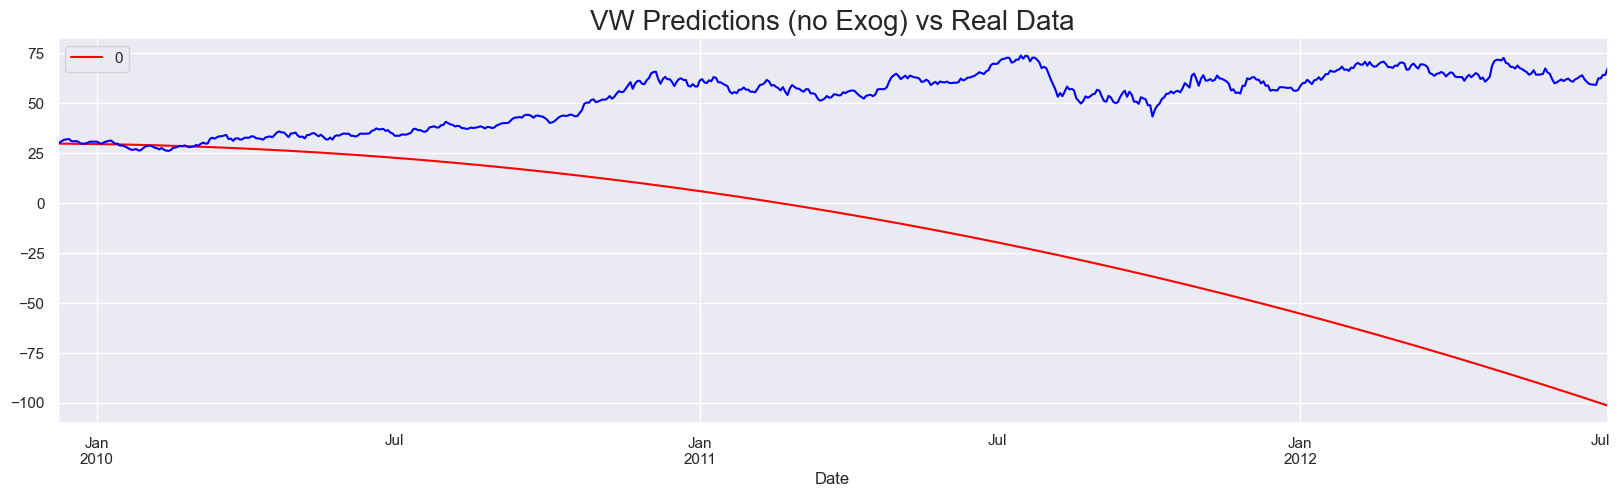

In [51]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = 'ct')

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods =  len(df[ann_1:ann_2])), index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize=(20,5), color = 'red')

df.vol[ann_1:ann_2].plot(color = 'blue')
plt.title('VW Predictions (no Exog) vs Real Data', size = 20)
plt.show()

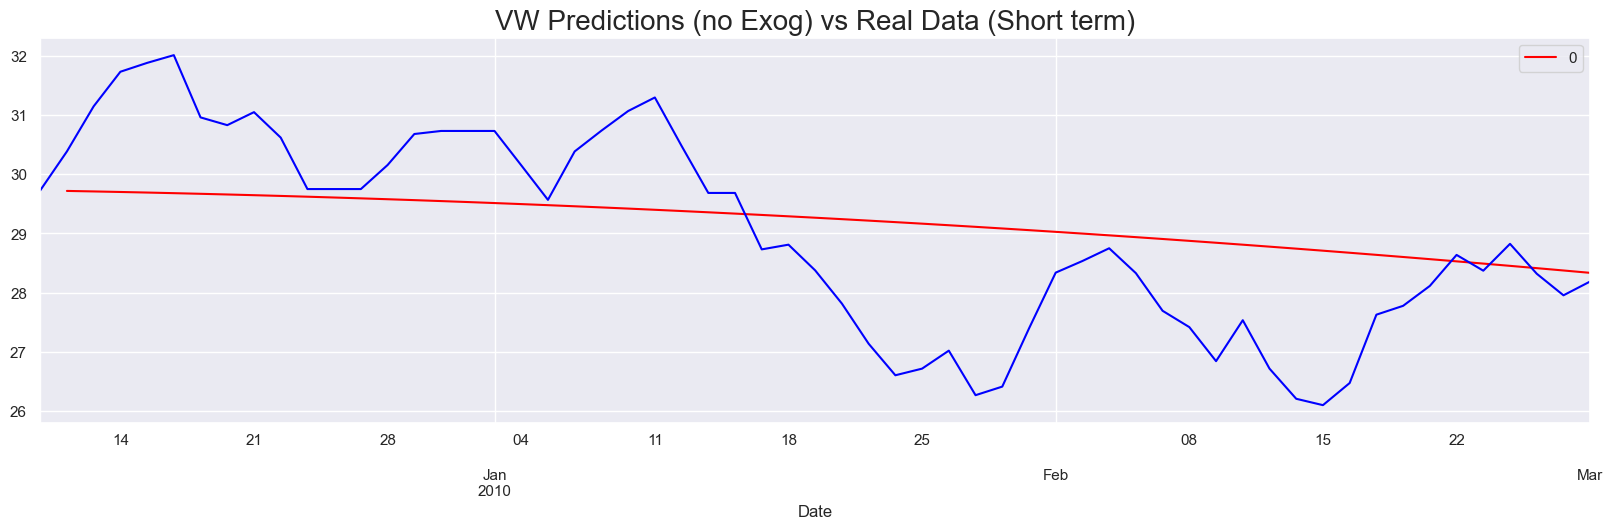

In [52]:
df_auto_pred_pr[ann_1:'2010-03-01'].plot(figsize=(20,5), color = 'red')

df.vol[ann_1:'2010-03-01'].plot(color = 'blue')
plt.title('VW Predictions (no Exog) vs Real Data (Short term)', size = 20)
plt.show()

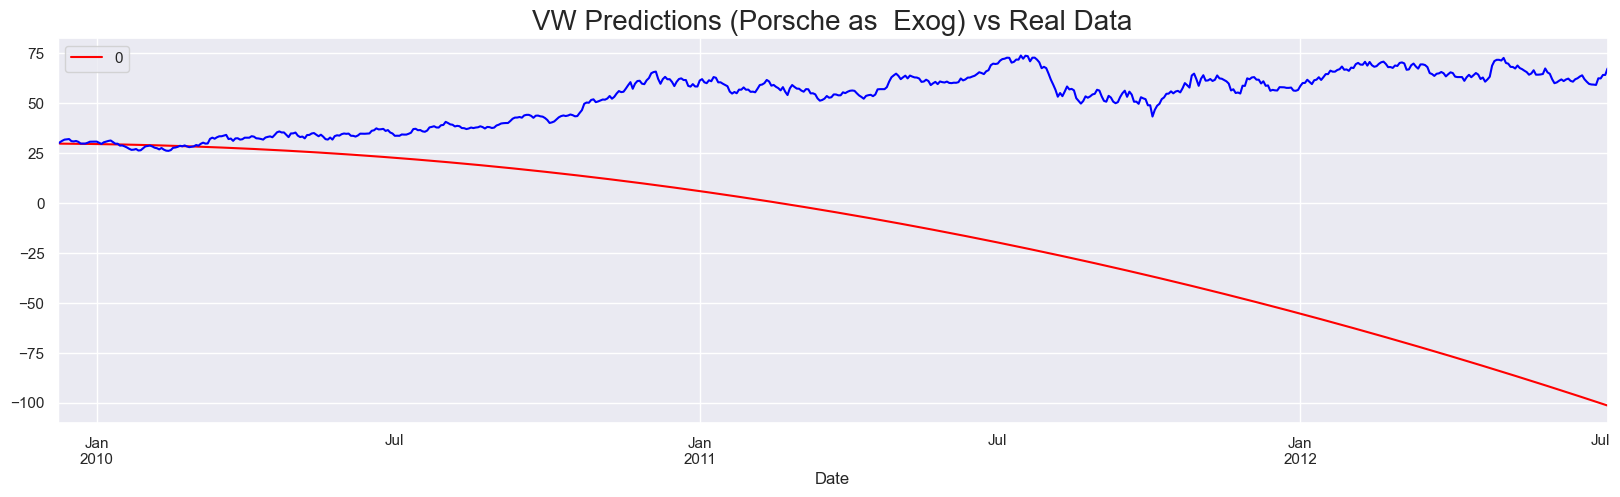

In [53]:
# Using porsche data as exogenous variables

model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous = df[['por']][start_date:ann_1],
                                 m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = 'ct')

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods =  len(df[ann_1:ann_2]),exogenous = df[['por']][ann_1:ann_2]),
                               index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize=(20,5), color = 'red')

df.vol[ann_1:ann_2].plot(color = 'blue')
plt.title('VW Predictions (Porsche as  Exog) vs Real Data', size = 20)
plt.show()

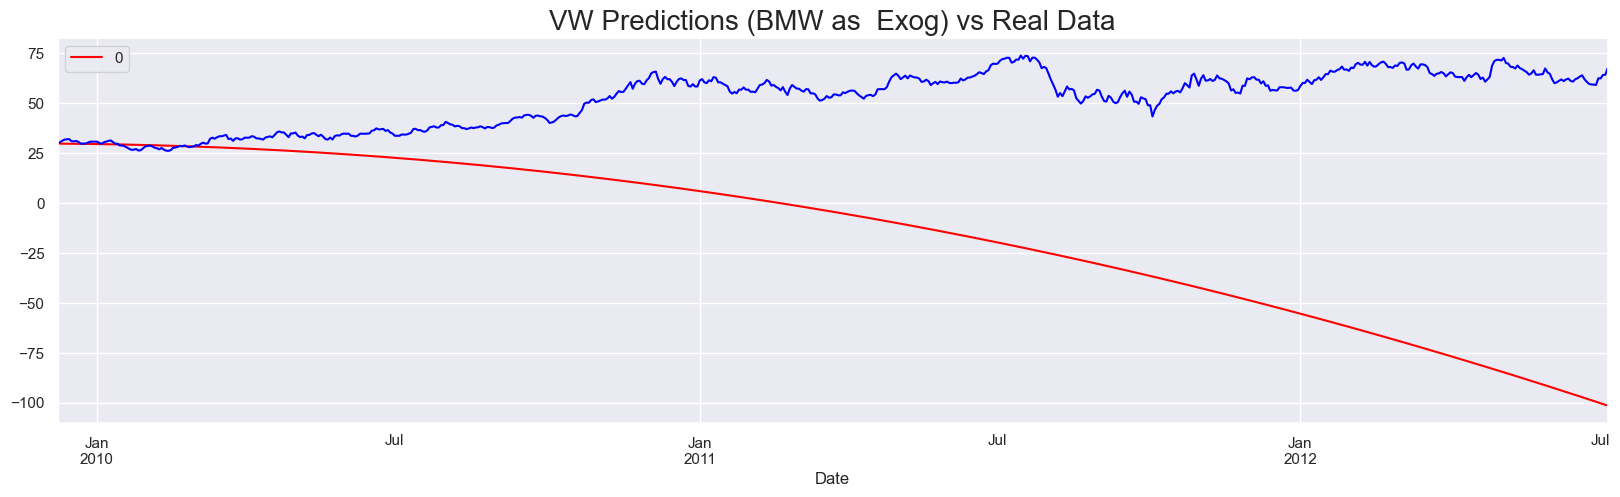

In [67]:
# Using bmw (the market bechmark) data as exogenous variables

model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous = df.loc[start_date:ann_1, ['bmw']],
                                 m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = 'ct')

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods =  len(df[ann_1:ann_2]),exogenous= df.loc[ann_1:ann_2, ['bmw']]),
                               index = df[ann_1:ann_2].index)
df_auto_pred_pr.plot(figsize=(20,5), color = 'red')

df.vol[ann_1:ann_2].plot(color = 'blue')
plt.title('VW Predictions (BMW as  Exog) vs Real Data', size = 20)
plt.show()

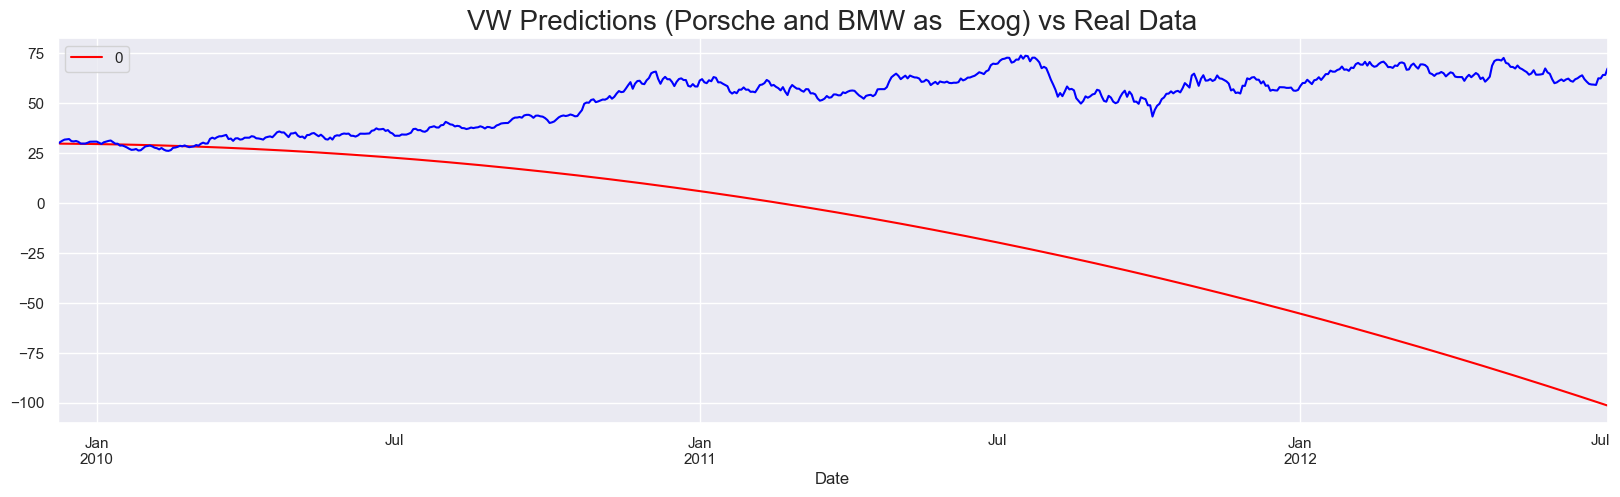

In [68]:
# Using both as exogenous variables

model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous = df[['por','bmw']][start_date:ann_1],
                                 m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = 'ct')

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods =  len(df[ann_1:ann_2]),exogenous = df[['por','bmw']][ann_1:ann_2]),
                               index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize=(20,5), color = 'red')

df.vol[ann_1:ann_2].plot(color = 'blue')
plt.title('VW Predictions (Porsche and BMW as  Exog) vs Real Data', size = 20)
plt.show()

#### Volatality

##### Volatality of VW for each period

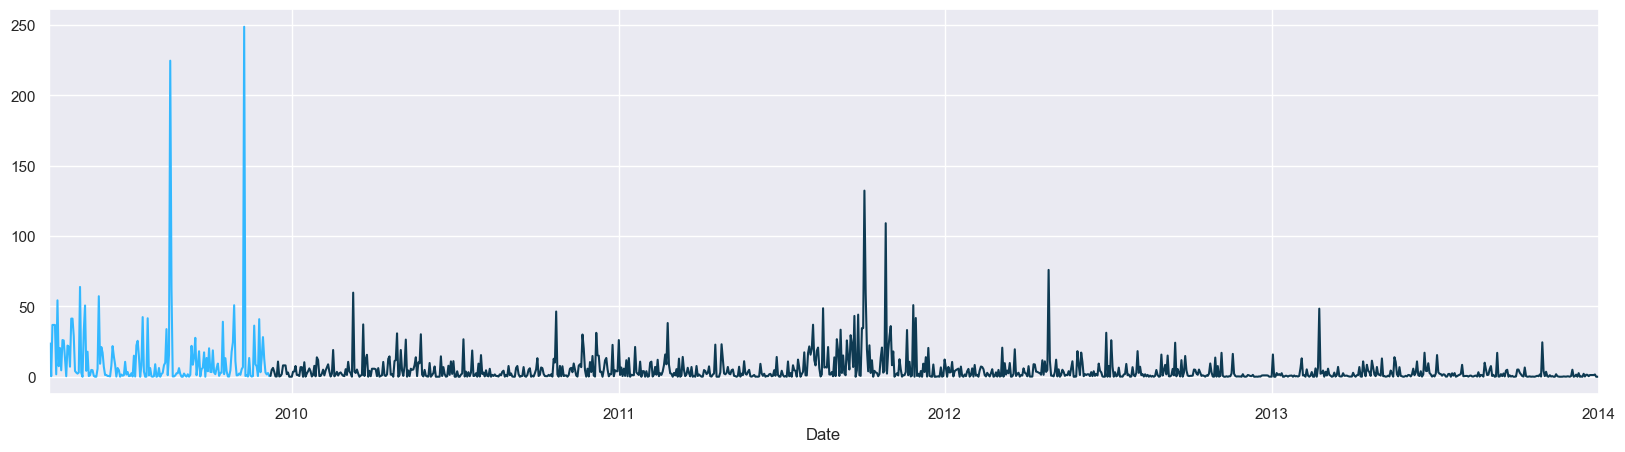

In [69]:
df['sq_vol'][start_date:ann_1].plot(figsize=(20,5),color = '#33B8ff')
df['sq_vol'][ann_1:ann_2].plot(color = '#0E3A52')
df['sq_vol'][ann_2:end_date].plot(color = '#0E3A52')
plt.show()

##### Volatality Trends for Each period

In [70]:
model_garch_pre = arch_model(df.ret_vol[start_date:ann_1], mean = 'Constant', vol = "GARCH", p = 1, q = 1)
results_garch_pre = model_garch_pre.fit(update_freq = 5)

model_garch_btn = arch_model(df.ret_vol[ann_1:ann_2], mean = 'Constant', vol = "GARCH", p = 1, q = 1)
results_garch_btn = model_garch_btn.fit(update_freq = 5)

model_garch_post = arch_model(df.ret_vol[ann_2:end_date], mean = 'Constant', vol = "GARCH", p = 1, q = 1)
results_garch_post = model_garch_post.fit(update_freq = 5)

Iteration:      5,   Func. Count:     31,   Neg. LLF: 478.87883483075245
Iteration:     10,   Func. Count:     58,   Neg. LLF: 668.2479263790993
Optimization terminated successfully    (Exit mode 0)
            Current function value: 477.5319817954765
            Iterations: 11
            Function evaluations: 63
            Gradient evaluations: 10
Iteration:      5,   Func. Count:     37,   Neg. LLF: 1520.0106263618754
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1519.9879102532525
            Iterations: 8
            Function evaluations: 53
            Gradient evaluations: 8
Iteration:      5,   Func. Count:     33,   Neg. LLF: 718.0817389681288
Iteration:     10,   Func. Count:     58,   Neg. LLF: 717.9163939195209
Optimization terminated successfully    (Exit mode 0)
            Current function value: 717.916393919283
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10


In [71]:
results_garch_pre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -477.532
Distribution:                  Normal   AIC:                           963.064
Method:            Maximum Likelihood   BIC:                           975.791
                                        No. Observations:                  178
Date:                Wed, May 21 2025   Df Residuals:                      177
Time:                        12:12:22   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.3187      0.265      1.201      0.230 [ -0.201,  0.839]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.5889      0.437      1.348      0.178      [ -0.267,  1.445]
alpha[1]   1.1544e-08  1.341e-02  8.610e-07      1.000 [-2.628e-02,2.628e-02]
beta[1]        0.9491  4.176e-02     22.728 2.367e-114      [  0.867,  1.031]
=============================================================================

Covariance estimator: robust
"""

In [72]:
results_garch_btn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1519.99
Distribution:                  Normal   AIC:                           3047.98
Method:            Maximum Likelihood   BIC:                           3066.02
                                        No. Observations:                  672
Date:                Wed, May 21 2025   Df Residuals:                      671
Time:                        12:12:22   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1792  8.598e-02      2.084  3.718e-02 [1.064e-02,  0.348]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.1597  7.533e-02      2.120  3.402e-02   [1.204e-02,  0.307]
alpha[1]       0.0615  1.503e-02      4.094  4.244e-05 [3.208e-02,9.101e-02]
beta[1]        0.9116  1.932e-02     47.181      0.000     [  0.874,  0.950]
============================================================================

Covariance estimator: robust
"""

In [73]:
results_garch_post.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -717.916
Distribution:                  Normal   AIC:                           1443.83
Method:            Maximum Likelihood   BIC:                           1459.70
                                        No. Observations:                  390
Date:                Wed, May 21 2025   Df Residuals:                      389
Time:                        12:12:22   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1819  9.500e-02      1.915  5.550e-02 [-4.276e-03,  0.368]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.4608      0.517      0.892      0.373   [ -0.552,  1.474]
alpha[1]       0.1250      0.146      0.855      0.393   [ -0.162,  0.412]
beta[1]        0.6837      0.308      2.222  2.631e-02 [8.053e-02,  1.287]
==========================================================================

Covariance estimator: robust
"""